In [1]:
# Import necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from xgboost import XGBClassifier, plot_tree, to_graphviz
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import graphviz
import warnings

In [2]:
# Set options
np.set_printoptions(formatter={'float_kind': '{:f}'.format})
sns.set(rc={'figure.figsize': (8, 6)})
warnings.filterwarnings('ignore')

In [3]:
# Load data
raw_data = pd.read_csv('/kaggle/input/cyberattacks-2014-2023-q1/cyberattacks.csv', encoding='latin-1')
raw_data.rename(columns={'ï»¿Date': 'Date', 'Region (Continent)': 'Region', 'Type': 'Attacktype', 'Days': 'Attackdays'}, inplace=True)
raw_data['Day'] = pd.DatetimeIndex(raw_data['Date']).day
raw_data['Month'] = pd.DatetimeIndex(raw_data['Date']).month
raw_data['Year'] = pd.DatetimeIndex(raw_data['Date']).year
raw_data2 = raw_data[['Day', 'Month', 'Year', 'Location', 'Region', 'Industry', 'Attacktype', 'Attackdays', 'Rate']]
raw_data2.head()

,Day,Month,Year,Location,Region,Industry,Attacktype,Attackdays,Rate
0,1,1,2014,USA,North America,"Professional, Scientific, and Technical Services",Exploitative,5,1
1,1,1,2014,USA,North America,"Professional, Scientific, and Technical Services",Disruptive,8,0
2,1,1,2014,USA,North America,Educational Services,Exploitative,6,1
3,2,1,2014,USA,North America,Information,Exploitative,1,1
4,3,1,2014,USA,North America,Information,Disruptive,8,1


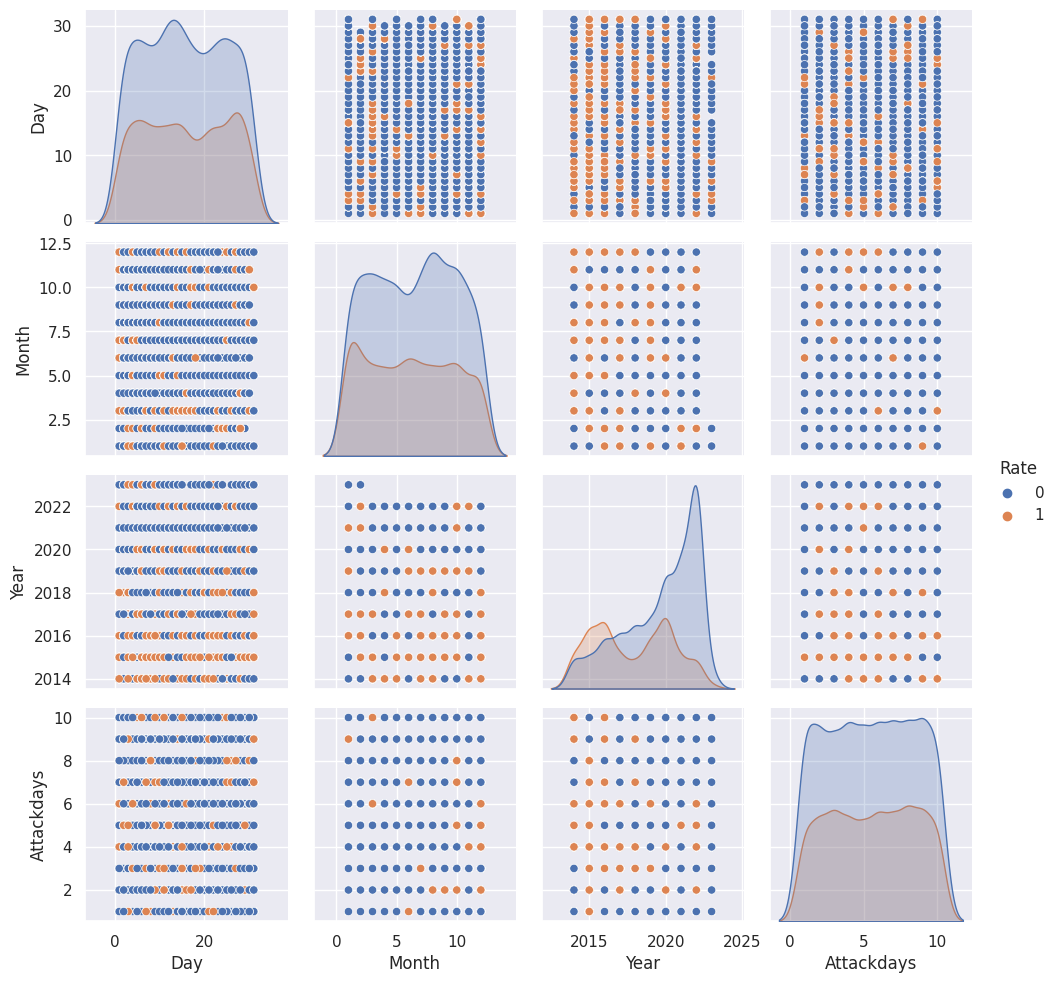

In [4]:
# Data preprocessing and visualization
sns.pairplot(raw_data2, hue='Rate', diag_kws={'bw': 0.2})
features = ['Day', 'Month', 'Year', 'Location', 'Region', 'Industry', 'Attacktype', 'Attackdays']
new_raw_data = pd.get_dummies(raw_data2, columns=['Location', 'Region', 'Industry', 'Attacktype'])

In [5]:
# Splitting data
X = new_raw_data.drop('Rate', axis=1).values
y = new_raw_data['Rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=0)

In [6]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """Plots a confusion matrix with seaborn heatmap."""
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Training Accuracy (Decision Tree):  0.998998096383128
Testing Accuracy (Decision Tree):  0.7621621621621621


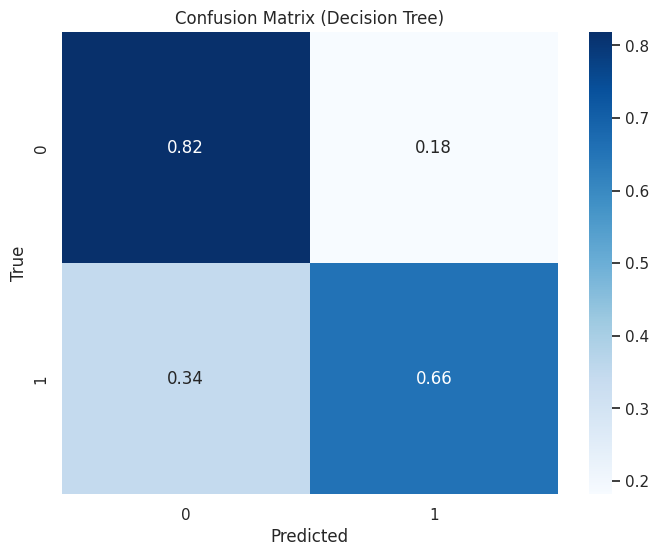

In [7]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Training and testing accuracy
print("Training Accuracy (Decision Tree): ", dt.score(X_train, y_train))
print("Testing Accuracy (Decision Tree): ", dt.score(X_test, y_test))

# Confusion matrix
y_pred_dt = dt.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt, classes=dt.classes_, title='Confusion Matrix (Decision Tree)')

#Visualize the structure of the model
dot_data = export_graphviz(dt, out_file=None, feature_names=new_raw_data.drop('Rate', axis=1).columns,
                           class_names=new_raw_data['Rate'].unique().astype(str), filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)

Training Accuracy (Random Forest):  0.9988979060214407
Testing Accuracy (Random Forest):  0.809009009009009


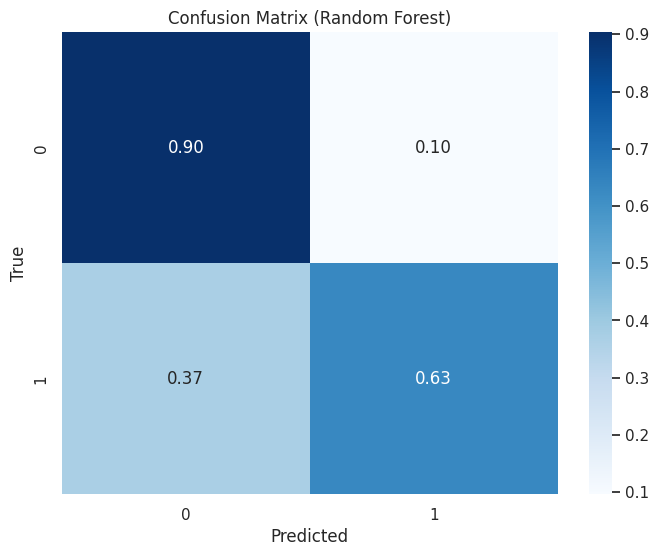

In [8]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Training and testing accuracy
train_accuracy_rf = rf.score(X_train, y_train)
test_accuracy_rf = rf.score(X_test, y_test)
print("Training Accuracy (Random Forest): ", train_accuracy_rf)
print("Testing Accuracy (Random Forest): ", test_accuracy_rf)

# Confusion matrix
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, classes=rf.classes_, title='Confusion Matrix (Random Forest)')

# Visualize the first three decision trees in the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names=new_raw_data.drop('Rate', axis=1).columns,
                               filled=True, max_depth=2, impurity=False, proportion=True)
    graph = graphviz.Source(dot_data)

Training accuracy (XGBoost):  0.7589419897805831
Testing accuracy (XGBoost):  0.7621621621621621


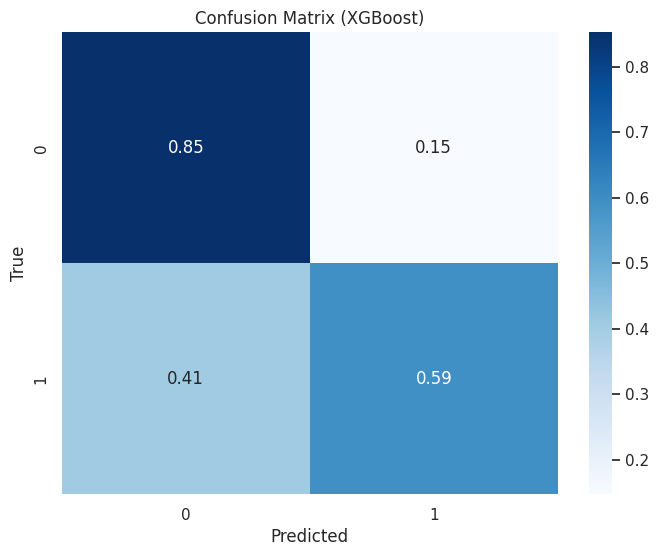

In [9]:
# XGBoost
xgb_classifier = XGBClassifier(n_estimators=100, tree_method='hist', eta=0.1, max_depth=3)
xgb_classifier.fit(X_train, y_train)

# Training and testing accuracy
print("Training accuracy (XGBoost): ", xgb_classifier.score(X_train, y_train))
print("Testing accuracy (XGBoost): ", xgb_classifier.score(X_test, y_test))

# Confusion matrix
y_pred_xgb = xgb_classifier.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(cm_xgb, classes=xgb_classifier.classes_, title='Confusion Matrix (XGBoost)')

In [10]:
# Hyperparameter tuning with RandomizedSearchCV
params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30], "max_depth": [2, 3, 4, 5, 6, 8, 10, 12, 15],
          "min_child_weight": [1, 3, 5, 7], "gamma": [0.0, 0.1, 0.2, 0.3, 0.4], "colsample_bytree": [0.3, 0.4, 0.5, 0.7]}
clf = RandomizedSearchCV(XGBClassifier(), param_distributions=params, n_iter=5, scoring='roc_auc', cv=5, verbose=3)
clf.fit(X, y)
best_model = clf.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.727 total time=   0.8s
[CV 2/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.001 total time=   0.9s
[CV 3/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.003 total time=   0.8s
[CV 4/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.091 total time=   0.8s
[CV 5/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.739 total time=   0.7s
[CV 1/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.3, max_depth=2, min_child_weight=7;, score=0.736 total time=   0.4s
[CV 2/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.3, max_depth=2, min_child_weight=7;, score=0.017 total time=   0.4s
[CV 3/5] END colsamp

In [11]:
# Deploying model on new unseen data
unseen_data = pd.read_csv('/kaggle/input/cyberattacks-2014-2023-q1/unseen data.csv', encoding='latin-1')
unseen_data.rename(columns={'ï»¿Date': 'Date', 'Region (Continents)': 'Region', 'Type': 'Attacktype', 'Days': 'Attackdays'}, inplace=True)
unseen_data['Day'] = pd.DatetimeIndex(unseen_data['Date']).day
unseen_data['Month'] = pd.DatetimeIndex(unseen_data['Date']).month
unseen_data['Year'] = pd.DatetimeIndex(unseen_data['Date']).year
unseen_data2 = unseen_data[['Day', 'Month', 'Year', 'Location', 'Region', 'Industry', 'Attacktype', 'Attackdays', 'Rate']]
new_unseen_data = pd.get_dummies(unseen_data2, columns=['Location', 'Region', 'Industry', 'Attacktype'])

In [12]:
# Making predictions
preds = best_model.predict(new_unseen_data.values)
pred_probs = best_model.predict_proba(new_unseen_data.values)

In [13]:
# Exporting predictions
output = unseen_data2.copy()
output['Predictions - Repeat or Not'] = preds
output['Predictions - Probability to Repeat'] = pred_probs[:, 1]
output['Predictions - Repeat or Not Desc'] = output['Predictions - Repeat or Not'].apply(lambda x: "Doesn't Repeat" if x == 1 else "Repeats")
output.dropna().to_csv('Attack_Predictions_Output.csv', sep='\t')

In [14]:
# Change working directory if needed
os.getcwd()

'/kaggle/working'